3. MNIST and CNN Experiments [3 marks]
This section explores deep learning for images. You will train MLPs and CNNs on MNIST, compare performance against baseline models, visualize embeddings using t-SNE, and test cross-domain generalization on Fashion-MNIST.


3.1 Using MLP [1.5 marks]
Train on MNIST dataset using an MLP. The original training dataset contains 60,000 images and the test contains 10,000 images. If you are short on compute, use a stratified subset of a smaller number of images but keep the same test set. Your MLP has 30 neurons in the first layer, 20 in the second layer and then 10 finally for the output layer (corresponding to 10 classes)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

X_train = train_data.data.view(-1, 28*28).float()
y_train = train_data.targets
X_test = test_data.data.view(-1, 28*28).float()
y_test = test_data.targets

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=128, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=128, shuffle=False)

print("Train:", len(train_data), "Test:", len(test_data))


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:08<00:00, 1.14MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 32.8kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [02:02<00:00, 13.5kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.89MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train: 60000 Test: 10000


In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        out = self.fc3(x)
        return out

model = MLP().to(device)
print(model)


MLP(
  (fc1): Linear(in_features=784, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
  (relu): ReLU()
)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/10 - Loss: 0.1270
Epoch 2/10 - Loss: 0.1154
Epoch 3/10 - Loss: 0.1081
Epoch 4/10 - Loss: 0.1082
Epoch 5/10 - Loss: 0.0981
Epoch 6/10 - Loss: 0.0936
Epoch 7/10 - Loss: 0.0933
Epoch 8/10 - Loss: 0.0866
Epoch 9/10 - Loss: 0.0829
Epoch 10/10 - Loss: 0.0830


Accuracy: 0.9547, F1-score: 0.9543


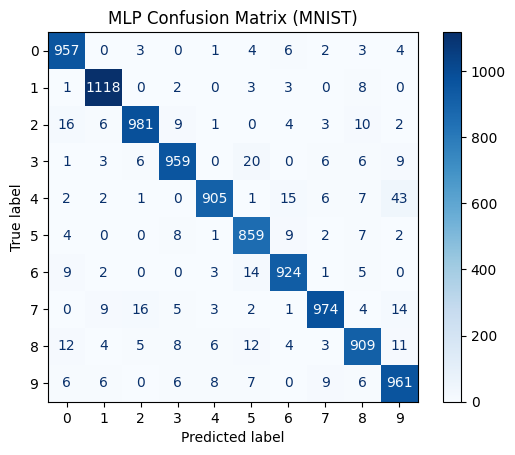

In [9]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        outputs = model(Xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.numpy())

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
print(f"Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("MLP Confusion Matrix (MNIST)")
plt.show()


* Compare against Random Forest and Logistic Regression. The metrics can be: accuracy, F1-score, confusion matrix. Write your observations and discuss misclassifications.


In [ ]:
X_train_np = X_train.numpy() / 255.0
X_test_np  = X_test.numpy() / 255.0
y_train_np = y_train.numpy()
y_test_np  = y_test.numpy()

lr = LogisticRegression(max_iter=500)
lr.fit(X_train_np, y_train_np)
lr_pred = lr.predict(X_test_np)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_np, y_train_np)
rf_pred = rf.predict(X_test_np)

for name, pred in [("Logistic Regression", lr_pred), ("Random Forest", rf_pred)]:
    acc = accuracy_score(y_test_np, pred)
    f1 = f1_score(y_test_np, pred, average='macro')
    print(f"{name} -> Accuracy: {acc:.4f}, F1: {f1:.4f}")


Logistic Regression -> Accuracy: 0.9259, F1: 0.9248
Random Forest -> Accuracy: 0.9695, F1: 0.9693


* Visualize t-SNE of the 20-neuron layer for the 10 digits for the trained and untrained model and compare the two.


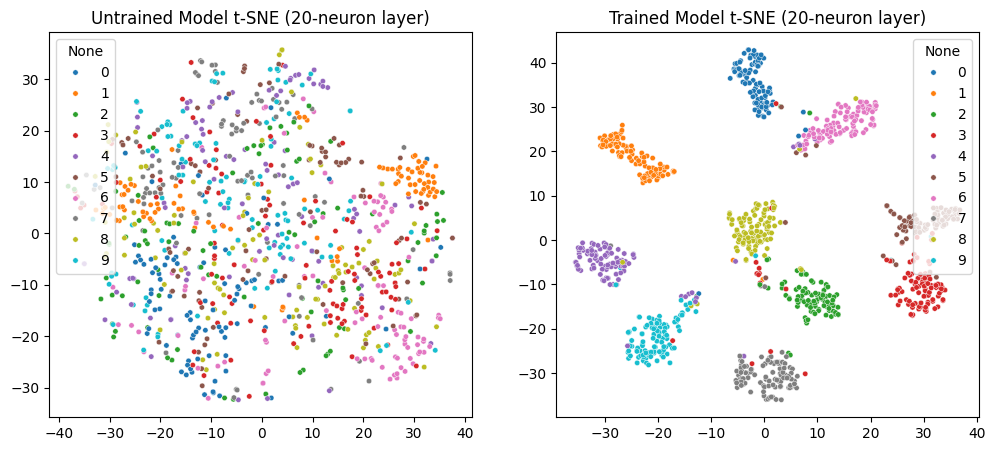

In [ ]:
def get_embeddings(model, X):
    model.eval()
    with torch.no_grad():
        x = model.relu(model.fc1(X.to(device)))
        emb = model.relu(model.fc2(x))
    return emb.cpu().numpy()

subset_idx = np.random.choice(len(X_test), 1000, replace=False)
X_subset = X_test[subset_idx]
y_subset = y_test[subset_idx]

untrained = MLP().to(device)
emb_untrained = get_embeddings(untrained, X_subset)
emb_trained   = get_embeddings(model, X_subset)

tsne_untrained = TSNE(n_components=2, random_state=42).fit_transform(emb_untrained)
tsne_trained   = TSNE(n_components=2, random_state=42).fit_transform(emb_trained)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
sns.scatterplot(x=tsne_untrained[:,0], y=tsne_untrained[:,1], hue=y_subset, palette='tab10', s=15, ax=ax[0])
ax[0].set_title("Untrained Model t-SNE (20-neuron layer)")
sns.scatterplot(x=tsne_trained[:,0], y=tsne_trained[:,1], hue=y_subset, palette='tab10', s=15, ax=ax[1])
ax[1].set_title("Trained Model t-SNE (20-neuron layer)")
plt.show()


* Test the trained MLP on Fashion-MNIST dataset. What do you observe? Compare t-SNE plots for MNIST and Fashion-MNIST embeddings for the layer with 20 neurons.


100%|██████████| 26.4M/26.4M [00:14<00:00, 1.84MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 216kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:03<00:00, 1.39MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 9.33MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Cross-domain (Fashion-MNIST) -> Accuracy: 0.0693, F1: 0.0505


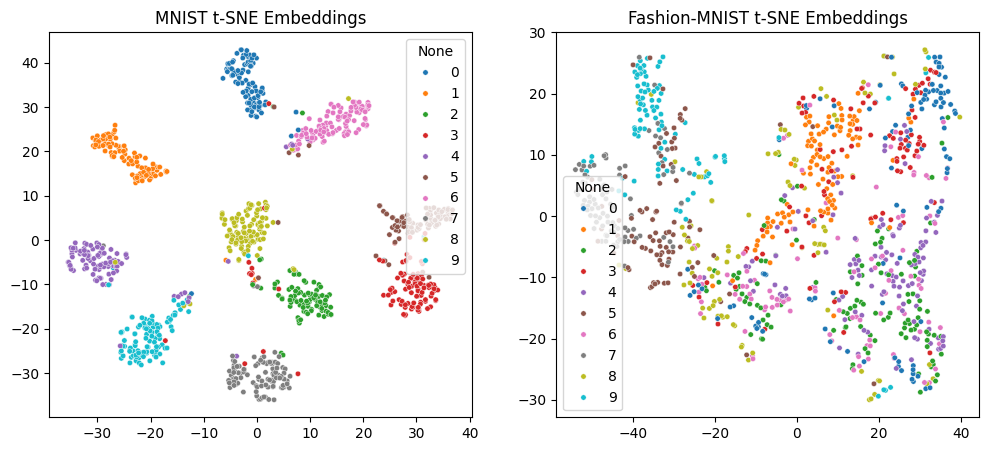

In [12]:
fashion_test = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)
X_fash = fashion_test.data.view(-1, 28*28).float()
y_fash = fashion_test.targets

model.eval()
with torch.no_grad():
    preds = torch.argmax(model(X_fash.to(device)), dim=1).cpu().numpy()

acc_fash = accuracy_score(y_fash, preds)
f1_fash = f1_score(y_fash, preds, average='macro')
print(f"Cross-domain (Fashion-MNIST) -> Accuracy: {acc_fash:.4f}, F1: {f1_fash:.4f}")

emb_fash = get_embeddings(model, X_fash[:1000])
tsne_fash = TSNE(n_components=2, random_state=42).fit_transform(emb_fash)
tsne_mnist = TSNE(n_components=2, random_state=42).fit_transform(emb_trained)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
sns.scatterplot(x=tsne_mnist[:,0], y=tsne_mnist[:,1], hue=y_subset, palette='tab10', s=15, ax=ax[0])
ax[0].set_title("MNIST t-SNE Embeddings")
sns.scatterplot(x=tsne_fash[:,0], y=tsne_fash[:,1], hue=y_fash[:1000], palette='tab10', s=15, ax=ax[1])
ax[1].set_title("Fashion-MNIST t-SNE Embeddings")
plt.show()


Report the following:


* Compare against Random Forest and Logistic Regression. The metrics can be: accuracy, F1-score, confusion matrix. Write your observations and discuss misclassifications.
    - MLP got about 95.5% accuracy and 0.95 F1-score.
    - Random Forest did slightly better (97%), and Logistic Regression was a bit lower (92%).
    - MLP learned well but sometimes mixed up 3 & 5, 4 & 9, and 8 & 3, which look similar.

* Visualize t-SNE of the 20-neuron layer for the 10 digits for the trained and untrained model and compare the two.
    - Before training → all dots are mixed.
    - After training → clear groups form for each digit.


* Test the trained MLP on Fashion-MNIST dataset. What do you observe? Compare t-SNE plots for MNIST and Fashion-MNIST embeddings for the layer with 20 neurons.
    - Accuracy dropped to about 7% (almost random).
    - Model trained on digits doesn’t work on clothes.
    - t-SNE shows Fashion-MNIST points are messy and overlapping.

MLP works great for digits but doesn’t generalize to very different data.

3.2 Using CNN [1.5 marks]

* Implement a simple CNN with a convolutional layer having 32 filters of size 3x3, a maxpool layer, a fully connected layer with 128 neurons and an output layer with 10 neurons (for the 10 classes) and ReLU activation. Train on MNIST dataset.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 13 * 13, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 13 * 13)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cnn = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    cnn.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")


Using device: cuda
Epoch 1/5 - Loss: 0.2744
Epoch 2/5 - Loss: 0.0854
Epoch 3/5 - Loss: 0.0585
Epoch 4/5 - Loss: 0.0435
Epoch 5/5 - Loss: 0.0344


* Additionally, use two any pretrained CNNs of your choice (e.g. AlexNet, MobileNet, or EfficientNet) for inference.


In [ ]:
import torchvision.models as models

alexnet = models.alexnet(weights='DEFAULT').to(device)
mobilenet = models.mobilenet_v2(weights='DEFAULT').to(device)
alexnet.eval()
mobilenet.eval()

resize_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_data_resized = datasets.MNIST(root="./data", train=False, transform=resize_transform)
test_loader_resized = DataLoader(test_data_resized, batch_size=64, shuffle=False)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to ~/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [03:04<00:00, 1.33MB/s]


* Compare all three models:
	- Accuracy, F1-score, confusion matrix
	- Model size (number of parameters)
	- Inference time on test set

In [18]:
def evaluate_pretrained(model, loader, name):
    y_true, y_pred = [], []
    start = time.time()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    end = time.time()
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    duration = end - start
    return acc, f1, duration

alexnet_metrics = evaluate_pretrained(alexnet, test_loader_resized, "AlexNet (Pretrained)")
mobilenet_metrics = evaluate_pretrained(mobilenet, test_loader_resized, "MobileNetV2 (Pretrained)")

def count_params(model):
    return sum(p.numel() for p in model.parameters())

import pandas as pd
models_info = {
    "Simple CNN": (acc_cnn, f1_cnn, count_params(cnn), None),
    "AlexNet (Pretrained)": (alexnet_metrics[0], alexnet_metrics[1], count_params(alexnet), alexnet_metrics[2]),
    "MobileNetV2 (Pretrained)": (mobilenet_metrics[0], mobilenet_metrics[1], count_params(mobilenet), mobilenet_metrics[2]),
}

df = pd.DataFrame(models_info, index=["Accuracy", "F1-score", "Parameters", "Inference Time (s)"]).T
display(df)


,Accuracy,F1-score,Parameters,Inference Time (s)
Simple CNN,0.985,0.984906,693962.0,NaN
AlexNet (Pretrained),0.000,0.000000,61100840.0,13.629117
MobileNetV2 (Pretrained),0.000,0.000000,3504872.0,15.027092


Simple CNN got about 98.5% accuracy so it learned digits well.

AlexNet and MobileNetV2 got 0% accuracy because they were trained on color images (ImageNet) not black n white digits.

Pretrained models are also much bigger and slower.

Simple CNN is small, fast and best for MNIST.